# Question 1

## (a)

*Hint: use `seaborn.snsplot` to visualize data. use `np.corrcoef` to calculate the correlation matrix and use `seaborn.heatmap` to visualize the correlation matrix.*

In [1]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
compounds_df = pd.read_csv('../Datasets/compounds.csv')
compounds_df.head()

,A,B,C,D,type,Start assignment
0,6.4,2.9,4.3,1.3,amide,1
1,5.7,4.4,1.5,0.4,phenol,2
2,6.7,3.0,5.2,2.3,ether,0
3,5.8,2.8,5.1,2.4,ether,1
4,6.4,3.2,5.3,2.3,ether,0


In [3]:
# Standardize the data by dividing by the max value
features = compounds_df.drop(['type', 'Start assignment'], axis=1).values
X = features / np.max(features, axis=0)
print(f"X.shape: {X.shape}")

X.shape: (150, 4)


In [4]:
# Convert the numpy array to a DataFrame and add the type column
features_df = pd.DataFrame(X, columns=compounds_df.columns[:-2])
features_df['type'] = compounds_df['type']
features_df.head()

,A,B,C,D,type
0,0.810127,0.659091,0.623188,0.52,amide
1,0.721519,1.000000,0.217391,0.16,phenol
2,0.848101,0.681818,0.753623,0.92,ether
3,0.734177,0.636364,0.739130,0.96,ether
4,0.810127,0.727273,0.768116,0.92,ether


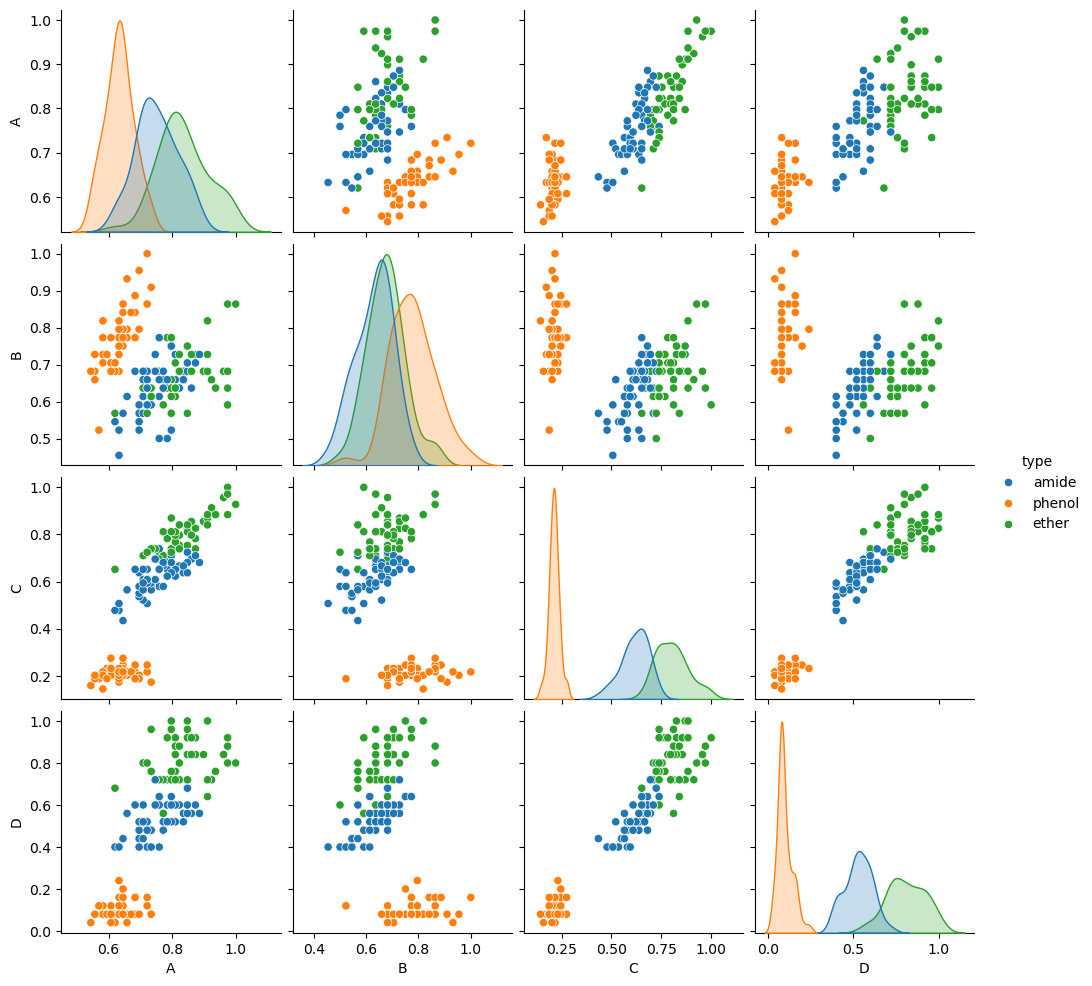

In [5]:
# Vizualize the data with sns.pairplot
sns.pairplot(data=features_df, hue='type')

In [6]:
corr_mat = np.corrcoef(X.T)
print(f"corr_mat.shape: {corr_mat.shape}")

corr_mat.shape: (4, 4)


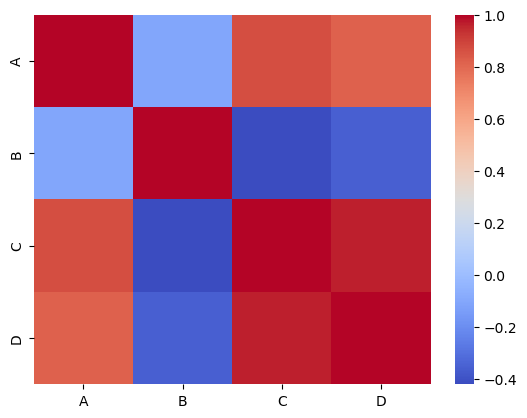

In [7]:
# Vizualize the correlation matrix
ax = sns.heatmap(corr_mat, cmap='coolwarm', xticklabels=features_df.columns[:-1], yticklabels=features_df.columns[:-1])

**ANSWER:** According to the correlation matrix, feature A seems correlated with features C and D, as well as features C and D together.

## (b)

### \[IMPORTANT\] Fill in and use the KMeans code below. DO NOT USE  `sklearn.cluster.KMeans`.

*Hint: To visualize the clusters, you can use `plt.scatter` and set the `c` parameters. Refer to Tutorial 5.*

In [8]:
import warnings
from scipy.spatial.distance import cdist


class KMeans():
    def __init__(self, n_clusters, max_iter=100):
        self.k = n_clusters
        self.max_iter = max_iter
    
    def cluster(self, X):
        """
        Do K-Means clustering
        
        Parameters
        ----------
        X: np.ndarray
            Normalized input features, shape (n_samples, n_features)
        """
        centroids = np.random.random((self.k, X.shape[1]))
        assignments = np.zeros(X.shape[0])
        new_assignments = self.create_new_assignments(centroids, X)
        
        # restart if run into bad initialization
        # Comment out this part for Q1.(d)
        if len(np.unique(new_assignments)) < self.k:
            return self.cluster(X)
        
        n_iters = 1
        while (new_assignments != assignments).any() and n_iters < self.max_iter:
            # compute centroids
            centroids = np.array([X[new_assignments == i].mean(axis=0) for i in range(self.k)])
            assignments = new_assignments
            # call the self.create_new_assignments
            new_assignments = self.create_new_assignments(centroids, X)
            if len(np.unique(new_assignments)) < self.k:
                warnings.warn('Warning: At least one centroid vanishes')
            n_iters += 1
            if n_iters == self.max_iter:
                warnings.warn("Warning: Maximum number of iterations reached!")
        return new_assignments
            
        
    def create_new_assignments(self, centroids, X):
        """
        Assign each datapoint to its nearest centroid.
        
        Parameters
        ----------
        centroids: np.ndarray
            Centroid of each cluster, shape (n_clusters, n_features)
        X: np.ndarray
            Input features, shape (n_samples, n_features)
        
        Returns
        ------
        new_assignments: np.ndarray
            Index of cluster which each data point belongs to, shape (n_samples,)
        """
        # Compute the distances that stores the Eucledian distances between each datapoints and the centroid
        # shape (n_samples, n_clusters)
        # Hint: you can use cdist in scipy.spatial.distance. 
        # cdist doc: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
        distances = cdist(X, centroids, metric='euclidean')
        new_assignments = np.argmin(distances, axis=-1)
        return new_assignments

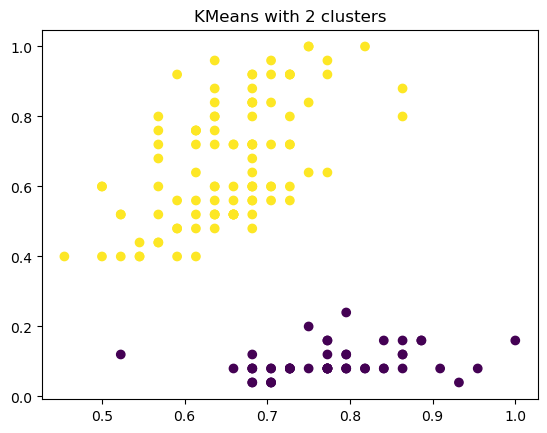

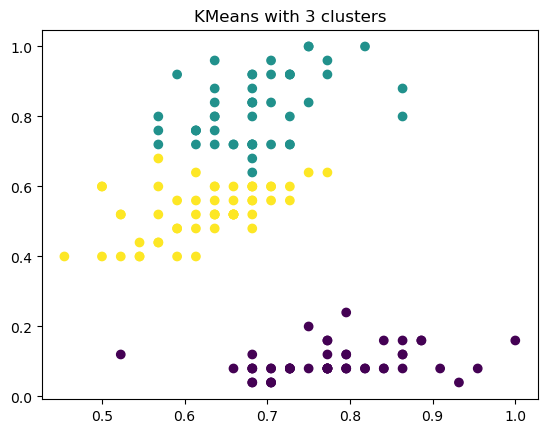

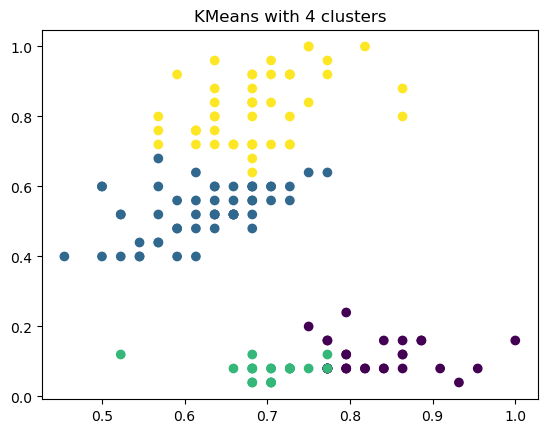

In [9]:
n_clusters_list = [2, 3, 4]

for n_clusters in n_clusters_list:
    kmeans = KMeans(n_clusters=n_clusters)
    assignments = kmeans.cluster(X)

    plt.figure()
    plt.scatter(X[:, 1], X[:, 3], c=assignments, cmap='viridis')
    plt.title(f'KMeans with {n_clusters} clusters')
    plt.show()


**ANSWER:** According to the vizualization we have, 2 clusters could work. But the value that makes more sense is clusters: according to the vizualizations, the KMeans with 3 clusters seems able to segment the samples, which is a good indication considering that we have 3 classes.

## (c)

### [IMPORTANT] Use the following function to validate your result. See the example in the docstring for usage.

*For debuging: you will get output like (not the same as) this*:

```
Class 0 - amide: 48 out of 50 are classified correctly
Class 1 - ether: 46 out of 50 are classified correctly
Class 2 - phenol: 50 out of 50 are classified correctly
```

In [10]:
def validate(y_pred, y_true, verbose: bool = True):
    """
    Validate the results of clustering
    
    Parameters
    ---------
    y_pred: np.ndarray
        Predicted clusters
    y_true: list or np.ndarray
        Ground truth clusters
    
    Example
    ------
    >>> validate(model.cluster(features), df['type'].values)
    """
    # correct classification
    compounds = np.unique(y_true) # should be ['amide','phenol','ether'] for compounds dataset
    clusters = [np.where(y_true == c)[0] for c in compounds]
    pred_class = np.unique(y_pred)
    
    #remove -1 for noise point in DBSCAN
    pred_class = np.delete(pred_class, np.where(pred_class == -1))
    assert len(pred_class) == len(compounds), \
        f'Predicted clusters has less or more than {len(compounds)} classes: {pred_class}'
    
    acc_counts = 0

    for i in range(3):
        #loop over solutions
        counts = []
        scores = []
        for j in range(3):
            # loop over clusters of true assignments
            sol_i = np.where(y_pred == pred_class[i])[0]
            counts.append(len(np.intersect1d(sol_i, clusters[j])))
            scores.append(counts[-1] / len(clusters[j]))
        idx = np.argmax(scores)
        if verbose:
            print(
                f'Class {pred_class[i]} - {compounds[idx]}: {counts[idx]} out of {len(clusters[j])}'
                ' are classified correctly'
            ) 
        acc_counts += counts[idx]

    accuracy = acc_counts / len(y_true)
    if verbose:
        print(f'Accuracy: {accuracy * 100:.2f}%')
    return accuracy

In [11]:
kmeans = KMeans(n_clusters=3)
val = validate(kmeans.cluster(X), compounds_df['type'].values)

Class 0 - amide: 48 out of 50 are classified correctly
Class 1 - phenol: 50 out of 50 are classified correctly
Class 2 - ether: 46 out of 50 are classified correctly
Accuracy: 96.00%


**ANSWER:** The classification seems pretty good, with a total accuracy of 96% on average.

## (d)

In [12]:
class KMeansWithoutRestart():
    def __init__(self, n_clusters, max_iter=100):
        self.k = n_clusters
        self.max_iter = max_iter
    
    def cluster(self, X):
        """
        Do K-Means clustering
        
        Parameters
        ----------
        X: np.ndarray
            Normalized input features, shape (n_samples, n_features)
        """
        centroids = np.random.random((self.k, X.shape[1]))
        assignments = np.zeros(X.shape[0])
        new_assignments = self.create_new_assignments(centroids, X)
        
        n_iters = 1
        while (new_assignments != assignments).any() and n_iters < self.max_iter:
            # compute centroids
            centroids = np.array([X[new_assignments == i].mean(axis=0) for i in range(self.k)])
            assignments = new_assignments
            # call the self.create_new_assignments
            new_assignments = self.create_new_assignments(centroids, X)
            if len(np.unique(new_assignments)) < self.k:
                warnings.warn('Warning: At least one centroid vanishes')
            n_iters += 1
            if n_iters == self.max_iter:
                warnings.warn("Warning: Maximum number of iterations reached!")
        return new_assignments
            
        
    def create_new_assignments(self, centroids, X):
        """
        Assign each datapoint to its nearest centroid.
        
        Parameters
        ----------
        centroids: np.ndarray
            Centroid of each cluster, shape (n_clusters, n_features)
        X: np.ndarray
            Input features, shape (n_samples, n_features)
        
        Returns
        ------
        new_assignments: np.ndarray
            Index of cluster which each data point belongs to, shape (n_samples,)
        """
        # Compute the distances that stores the Eucledian distances between each datapoints and the centroid
        # shape (n_samples, n_clusters)
        # Hint: you can use cdist in scipy.spatial.distance. 
        # cdist doc: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
        distances = cdist(X, centroids, metric='euclidean')
        new_assignments = np.argmin(distances, axis=-1)
        return new_assignments

In [13]:
ntrials = 1000
count = 0
for i in range(ntrials):
    kmeans = KMeansWithoutRestart(n_clusters=4) # Comment out the re-init code in KMeans
    results = kmeans.cluster(features)
    if len(np.unique(results)) == 4:
        count += 1
print(f'\nOut of {ntrials} number of KMeans trials, only {count} gives 4 clusters')

/var/folders/8w/hjszh63d3c73r_p9_djpkmkh0000gn/T/ipykernel_50131/2576263695.py:22: RuntimeWarning: Mean of empty slice.
  centroids = np.array([X[new_assignments == i].mean(axis=0) for i in range(self.k)])
/Users/adn/anaconda3/envs/bioe242/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/var/folders/8w/hjszh63d3c73r_p9_djpkmkh0000gn/T/ipykernel_50131/2576263695.py:27: UserWarning: Warning: At least one centroid vanishes
  warnings.warn('Warning: At least one centroid vanishes')
/var/folders/8w/hjszh63d3c73r_p9_djpkmkh0000gn/T/ipykernel_50131/2576263695.py:30: UserWarning: Warning: Maximum number of iterations reached!
  warnings.warn("Warning: Maximum number of iterations reached!")



Out of 1000 number of KMeans trials, only 2 gives 4 clusters


**ANSWER:** The problem is that the KMeans algorithm might not converge to the correct solution if the initial centroids are not chosen properly. It could also lead to inconsistent results across runs: we get widely varying clustering results across different runs of the algorithm. 

This choice might affect the results because the algorithm might converge to a local minimum, that takes into account the required number of clusters. It would also affect the speed of convergence: good initial centroids can lead to faster convergence.


Potential solutions could be: 
+ Running multiple random initializations choosing the result with the lowest sum of squared distances from points to their respective centroids.
+ Leveraging domain knowledge: knowing the distribution of data could help us to smartly initialize the centroids.
+ Another solution described on the internet is K-Means++ initialization, which selects initial centroids in a way that spreads them out over the data distribution and significantly improves the chances of finding a global optimum.



# Question 2

## (a)

*Hint*:
+ Use `sklearn.cluster.DBSCAN` and adjust `eps`(Rcut) and `min_samples`(MinPts) parameters.**
+ Core points are stored in `core_sample_indices_` attribute.
+ Cluster results are stored in `labels_` attribute and noise points are labeled as -1.


In [14]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.1, min_samples=5)
db.fit(X)
print(f"db.core_sample_indices_: {db.core_sample_indices_}")
print(f"db.labels_: {db.labels_}")

db.core_sample_indices_: [  0   2   4   5   7   8   9  10  12  13  14  15  16  17  18  19  20  21
  24  25  26  27  28  29  31  32  36  37  38  39  40  41  43  44  45  46
  47  48  51  54  55  57  58  59  60  61  62  63  64  65  66  67  68  69
  71  72  73  74  75  76  77  78  79  81  82  83  84  85  87  88  89  90
  92  93  95  96  98  99 100 101 102 103 104 105 106 107 108 109 111 112
 114 115 116 117 118 120 121 122 123 126 128 129 130 131 132 133 134 136
 137 138 139 141 142 143 144 145 146 148 149]
db.labels_: [ 0 -1  0 -1  0  1 -1  0  0  0  0 -1  1  0  1  1  0  0  0  1  1  0  0  0
  1  0  1  1  1  0 -1  1  0  1  0  0  1  0  0  1  0  0 -1  0  1  0  0  0
  0 -1 -1  0  0 -1  0  0 -1  0  0  1  1  0  1  0  0  1  0  1  0  0  1  1
  0  0  0  1  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0 -1  1  1  1  1
  0  0  0  1  0  0  0  0  0  1  1  1  1  0 -1  1  1 -1  0  0  1  1  1 -1
  1  1  1  0 -1 -1  0  0  0  1  0  0  0  0  0 -1  1  0  1  0  0  1  0  1
  0  1  0  0  0  0]


In [15]:
# Get the number of clusters, removing noise if present
n_clusters = len(np.unique(db.labels_)) - (1 if -1 in db.labels_ else 0)
print(f"Number of clusters: {n_clusters}")

Number of clusters: 2


In [16]:
# Create a grid search to find the best hyperparameters for DBSCAN (eps and min_samples)
best_score = 0
best_params = {}
for eps in np.linspace(0.01, 1, 100):
    for min_samples in range(1, 100):
        db = DBSCAN(eps=eps, min_samples=min_samples)
        db.fit(X)
        n_clusters = len(np.unique(db.labels_)) - (1 if -1 in db.labels_ else 0)
        if n_clusters != 3:
            continue
        else:
            score = validate(db.labels_, compounds_df['type'].values, verbose=False)

        if score > best_score:
            best_score = score
            best_params = {'eps': eps, 'min_samples': min_samples}

print(f"Best accuracy: {best_score * 100 :.2f}%")
print(f"Best params: {best_params}")


Best accuracy: 84.00%
Best params: {'eps': 0.09, 'min_samples': 5}


In [17]:
db = DBSCAN(**best_params)
db.fit(X)
val = validate(db.labels_, compounds_df['type'].values)
print(f"db.labels_: {db.labels_}")

Class 0 - amide: 47 out of 50 are classified correctly
Class 1 - ether: 33 out of 50 are classified correctly
Class 2 - phenol: 46 out of 50 are classified correctly
Accuracy: 84.00%
db.labels_: [ 0 -1  1 -1  1  2 -1  1  0  1  0 -1 -1  1  2  2  1  1  0  2  2  1 -1  1
  2  1  2  2  2  1 -1  2  1  2  0  0  2  1  0  2  0  0 -1  1  2  0  1  1
  0 -1 -1  0  1 -1  1  0 -1  0  1  2  2  0  2  0  1  2  0  2  0  0 -1  2
  0  1  0  2  1  0  0  0  0  2  2  0  1  0 -1  0  0  0  0 -1  2  2  2  2
  1  1  1  2  0  0  0  0  0  2  2  2  2  0 -1  2  2 -1  0  1  2  2  2 -1
  2  2  2  0 -1 -1  1  0  1  2  1  0  1  0  1 -1  2  0  2  0  1  2  0  2
  0  2  1  0  0  0]


In [18]:
# Calculate number of core, border and noise points
n_core = len(db.core_sample_indices_)
n_noise = np.sum(db.labels_ == -1)
n_border = X.shape[0] - n_core - n_noise
print(f"Number of core points: {n_core}")
print(f"Number of border points: {n_border}")
print(f"Number of noise points: {n_noise}")

Number of core points: 103
Number of border points: 26
Number of noise points: 21


**ANSWER:** DBSCAN seems here less effective than KMeans. The best accuracy we could get with DBSCAN is 84%, while KMeans gave us 96%.

## (b)

*Hint: To visualize the clusters, you can use `plt.scatter` and set the `c` parameters. Refer to Tutorial 5.*

In [19]:
from sklearn import datasets

def moon_dataset(n_samples=1500, form='moons'):
    """
    Generate datasets. We choose the size big enough to see the scalability
    of the algorithms, but not too big to avoid too long running times
    
    Parameters
    ---------
    n_samples: int
        Number of data points
    
    Returns
    ------
    X: np.ndarray
        Data points, shape (n_samples, 2)
    y: np.ndarray
        Clusters that each point belongs to, shape (n_samples)
    """
    np.random.seed(0)
    n_samples = 1500
    if form == 'moons':
        noisy_points = datasets.make_moons(n_samples=n_samples, noise=0.05)
    elif form == 'circles':
        noisy_points = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
    else:
        raise ValueError('form should be either "moons" or "circles"')
    
    X, y = noisy_points
    return X, y

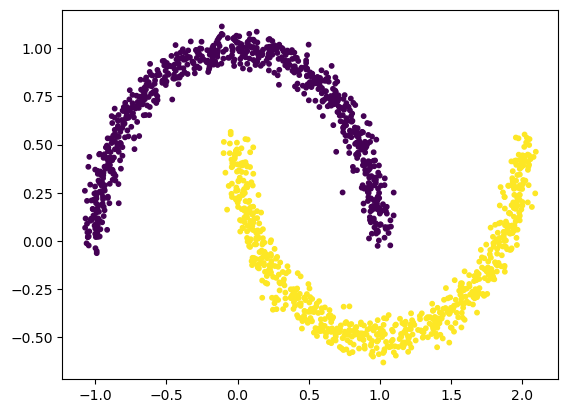

In [20]:
X, y = moon_dataset(form='moons')
plt.scatter(X[:, 0], X[:, 1], s=10, c=y, cmap='viridis')

First, we can begin by looking at the best parameters for DBSCAN. Let's create a validation function for adapted for the dataset and a grid search function for DBSCAN:

In [21]:
def validate_moon(y_pred, y_true, verbose: bool = True):
    """
    Validate the results of clustering
    
    Parameters
    ---------
    y_pred: np.ndarray
        Predicted clusters
    y_true: list or np.ndarray
        Ground truth clusters
    
    Example
    ------
    >>> validate(model.cluster(features), df['type'].values)
    """
    # correct classification
    moons = np.unique(y_true) 
    clusters = [np.where(y_true == c)[0] for c in moons]
    pred_class = np.unique(y_pred)

    #remove -1 for noise point in DBSCAN
    pred_class = np.delete(pred_class, np.where(pred_class == -1))
    assert len(pred_class) == len(moons), \
        f'Predicted clusters has less or more than {len(moons)} classes: {pred_class}'
    
    acc_counts = 0

    for i in range(len(moons)):
        #loop over solutions
        counts = []
        scores = []
        for j in range(len(moons)):
            # loop over clusters of true assignments
            sol_i = np.where(y_pred == pred_class[i])[0]
            counts.append(len(np.intersect1d(sol_i, clusters[j])))
            scores.append(counts[-1] / len(clusters[j]))
        idx = np.argmax(scores)
        if verbose:
            print(
                f'Class {pred_class[i]} - {moons[idx]}: {counts[idx]} out of {len(clusters[j])}'
                ' are classified correctly'
            ) 
        acc_counts += counts[idx]

    accuracy = acc_counts / len(y_true)
    if verbose:
        print(f'Accuracy: {accuracy * 100:.2f}%')
    return accuracy

In [22]:
def grid_search_DBSCAN(X, y, validation_fn):
    best_score = 0
    best_params = {}
    for eps in np.linspace(0.01, 1, 100):
        for min_samples in range(1, 100):
            db = DBSCAN(eps=eps, min_samples=min_samples)
            db.fit(X)
            try:
                score = validation_fn(db.labels_, y, verbose=False) 
            except AssertionError: # if the number of clusters is not equal to the number of classes
                continue

            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}
    return best_score, best_params

In [23]:
# Find the best hyperparameters for DBSCAN for the moon dataset
best_score, best_params = grid_search_DBSCAN(X, y, validate_moon)
print(f"Best params: {best_params}")

Best params: {'eps': 0.14, 'min_samples': 1}


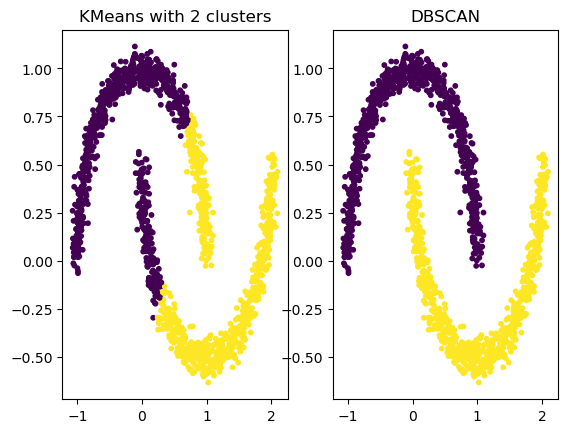

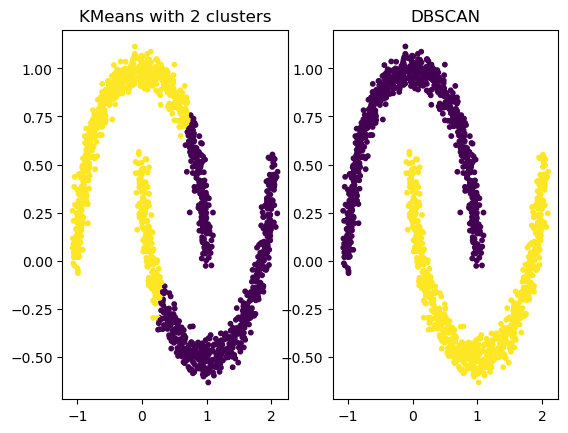

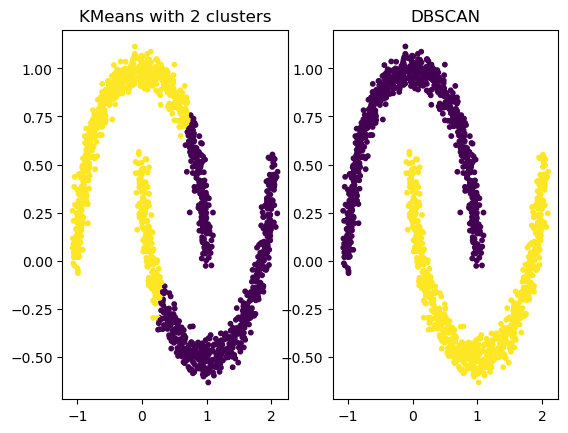

In [24]:
# Try using DBSCAN and KMeans with K=2. Run both algorithms with different initial conditions (say 3 times each)
for _ in range(3):
    kmeans = KMeans(n_clusters=2)
    y_kmeans_pred = kmeans.cluster(X)

    db = DBSCAN(**best_params)
    db.fit(X)
    y_db_pred = db.labels_

    plt.figure()
    plt.subplot(121)
    plt.scatter(X[:, 0], X[:, 1], c=y_kmeans_pred, s=10, cmap='viridis')
    plt.title('KMeans with 2 clusters')
    plt.subplot(122)
    plt.scatter(X[:, 0], X[:, 1], c=y_db_pred, s=10, cmap='viridis')
    plt.title('DBSCAN')
    plt.show()

We can also test for the circles dataset:

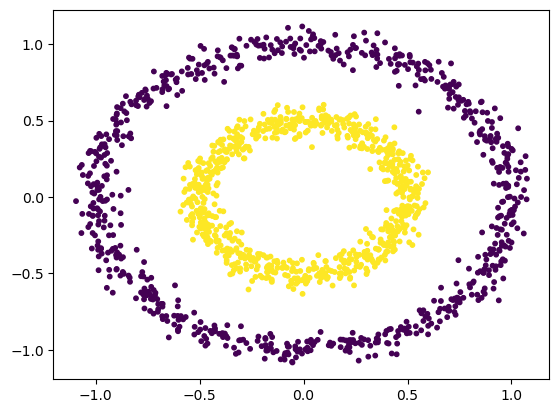

In [25]:
X, y = moon_dataset(form='circles')
plt.scatter(X[:, 0], X[:, 1], s=10, c=y, cmap='viridis')

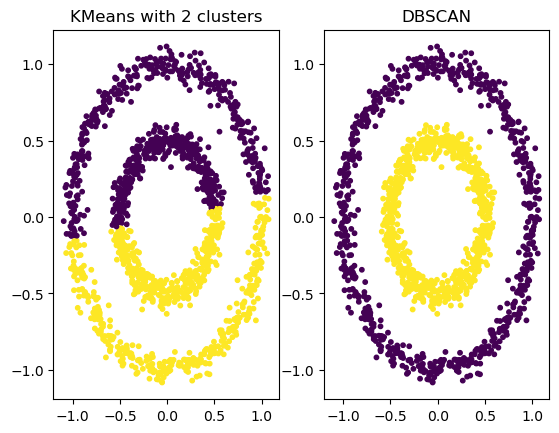

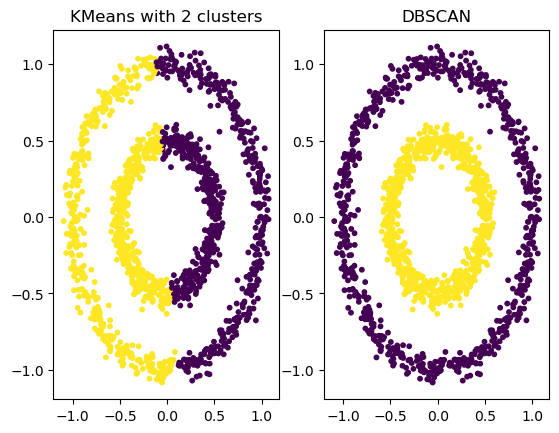

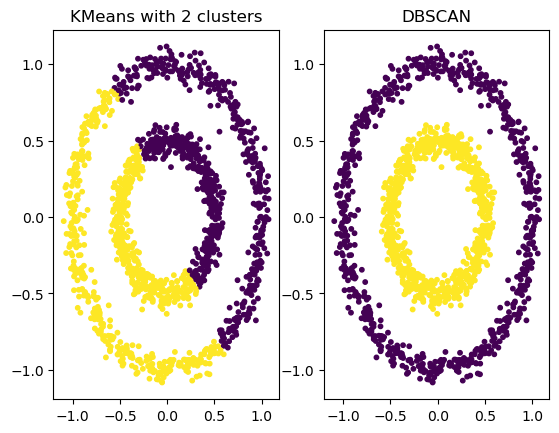

In [26]:
# Find the best hyperparameters for DBSCAN for the moon dataset
best_score, best_params = grid_search_DBSCAN(X, y, validate_moon)

# Try using DBSCAN and KMeans with K=2. Run both algorithms with different initial conditions (say 3 times each)
for _ in range(3):
    kmeans = KMeans(n_clusters=2)
    y_kmeans_pred = kmeans.cluster(X)

    db = DBSCAN(**best_params)
    db.fit(X)
    y_db_pred = db.labels_

    plt.figure()
    plt.subplot(121)
    plt.scatter(X[:, 0], X[:, 1], c=y_kmeans_pred, s=10, cmap='viridis')
    plt.title('KMeans with 2 clusters')
    plt.subplot(122)
    plt.scatter(X[:, 0], X[:, 1], c=y_db_pred, s=10, cmap='viridis')
    plt.title('DBSCAN')
    plt.show()

**ANSWER:** DBSCAN works better for the moon dataset. It is able to cluster the data points into two the two correct clusters. KMeans, on the other hand, is not able to cluster the data points into the two correct clusters.

# Question 3

## (a)

In [27]:
from sklearn.preprocessing import StandardScaler

In [28]:
compounds_df = pd.read_csv('../Datasets/compounds.csv')
compounds_df.head()

,A,B,C,D,type,Start assignment
0,6.4,2.9,4.3,1.3,amide,1
1,5.7,4.4,1.5,0.4,phenol,2
2,6.7,3.0,5.2,2.3,ether,0
3,5.8,2.8,5.1,2.4,ether,1
4,6.4,3.2,5.3,2.3,ether,0


In [29]:
# Standardize the data by subtracting off the mean and dividing by the standard deviation
scaler = StandardScaler()


features = compounds_df.drop(['type', 'Start assignment'], axis=1).values
features = scaler.fit_transform(features)
print(f"features.shape: {features.shape}")

clusters = compounds_df['Start assignment'].values
print(f"clusters.shape: {clusters.shape}")

features.shape: (150, 4)
clusters.shape: (150,)


## (b)

In [30]:
classes = np.unique(clusters)
centroids = []
for cls in classes:
    cls_filter = (clusters == cls)
    centroid = features[cls_filter].mean(axis=0)
    centroids.append(centroid)
    print(f"Centroid for {cls}  : {centroid}")

Centroid for 0  : [-0.03311922 -0.05553671 -0.0083403   0.0385654 ]
Centroid for 1  : [0.10985887 0.04165253 0.10425379 0.09115459]
Centroid for 2  : [-0.07673965  0.01388418 -0.09591349 -0.12972   ]


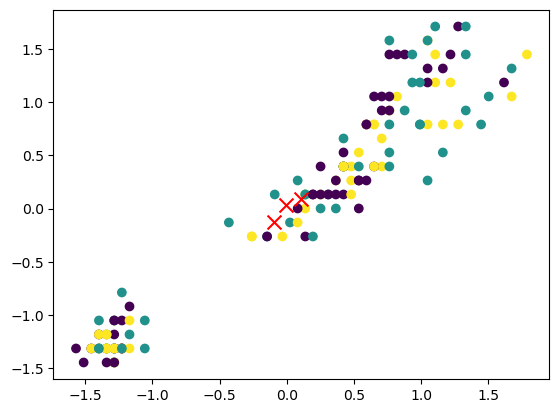

In [31]:
# Plot the data with plt.scatter and the centroids with plt.scatter, add cmap 
plt.scatter(features[:, 2], features[:, 3], c=clusters, cmap='viridis')
centroids = np.array(centroids)
plt.scatter(centroids[:, 2], centroids[:, 3], c='red', s=100, marker='x')
plt.show()

## (c)

*For debugging: should be 596.4585801741025*

In [32]:
# If you feel the code is slow in Q3(d), use numba to accelerate it
import numba

@numba.njit()
def cost_func(features, centroids, clusters):
    """
    Parameters
    ----------
    features: np.ndarray
        Feature matrix, shape (n_samples, n_features). In the compound dataset, n_features = 4.
    centroids: np.ndarray
        Centroids of each cluster, shape (n_cluster, n_features). In this question, n_cluster = 3.
    clusters: np.ndarray
        Cluster which each datapoint belongs to. shape (n_cluster,)
    """
    cost = 0

    for i in range(features.shape[0]):
        for j in range(centroids.shape[0]):
            if clusters[i] == j:
                # Compute the euclidean distance between the data point and the centroid
                cost += np.linalg.norm(features[i] - centroids[j])**2

    return cost
            

In [33]:
cost = cost_func(features, centroids, clusters)
print(f"Cost: {cost}")

Cost: 596.4585801741025


**ANSWER:** We have the same value of the cost function for this first assignment.

## (d)

*For debugging*: 
+ Cooling schedule should be like: `array([500. , 499.5, 499.0005, ..., 3.37065784, 3.36728719, 3.3639199])`
+ Cost function can drop to around 540 (or even smaller).

In [34]:
def compute_centroids(features, clusters, n_clusters):
    """
    Compute the centroids for each cluster
    
    Parameters
    ----------
    features: np.ndarray
        Feature matrix, shape (n_samples, n_features). In the compound dataset, n_features = 4.
    clusters: np.ndarray
        Cluster which each datapoint belongs to. shape (n_samples,)
    n_clusters: int
        Number of clusters
    """
    centroids = []
    for i in range(n_clusters):
        centroid = features[clusters == i].mean(axis=0)
        centroids.append(centroid)
    return np.array(centroids)

In [35]:
def SA(features, clusters, schedule, report_interval=100):
    """
    Simulated Annealing for clustering
    
    Parameters
    ----------
    features: numpy.ndarray
        Feature matrix. shape (n_samples, n_features)
    cluster: numpy.ndarray
        Initial guess of clusters. shape (n_samples,)
    schedule: numpy.ndarray
        Cooling schedule.
    report_interval: int
        Interval of steps to report result
    
    Returns
    ------
    res: dict
        Result containing the best clustering with the cost function value
    """
    # calculate the centroids
    centroids = compute_centroids(features, clusters, 3)
    # calulate the cost fucntion
    clusters_eval = cost_func(features, centroids, clusters)
    
    best_clusters = clusters.copy()
    lowest_eval = clusters_eval

    for step, temp in enumerate(schedule):
        if step % report_interval == 0:
            print(f"step: {step}, temp: {temp}, lowest_eval: {lowest_eval}")
        for n in range(features.shape[0]):
            trial = clusters.copy()
            # Do a Metroplis step by switching a sample to different cluster
            choices = [0, 1, 2]
            choices.remove(clusters[n]) # remove the current cluster
            rand_choice = np.random.choice(choices) # choose a different cluster
            trial[n] = rand_choice # switch the cluster
            
            # calculate the centroids & cost function
            trial_centroids = compute_centroids(features, trial, 3)
            trial_eval = cost_func(features, trial_centroids, trial)
            # Metroplis rule
            if np.exp(- (trial_eval - clusters_eval) / temp) > np.random.random():
                clusters = trial
                clusters_eval = trial_eval
                if trial_eval < lowest_eval:
                    best_clusters = clusters.copy()
                    lowest_eval = clusters_eval
                    
    return {"solution": best_clusters, "evaluation": lowest_eval}

In [36]:
def geometric_cooling(init_temp, num_steps, alpha):
    return init_temp * (alpha ** np.arange(num_steps))

In [37]:
schedule = geometric_cooling(500, 5000, 0.999)
print(f"Schedule: {schedule}")

Schedule: [500.         499.5        499.0005     ...   3.37065784   3.36728719
   3.3639199 ]


**ANSWER:** The schedule array seems to the same as the debugging one.

In [38]:
for i in range(3):
    print(f"## Trial {i + 1} ##")
    res = SA(features, clusters, schedule, report_interval=500)
    validate(res['solution'], compounds_df['type'].values)
    print()

## Trial 1 ##
step: 0, temp: 500.0, lowest_eval: 596.4585801741025
step: 500, temp: 303.18947243059233, lowest_eval: 535.4708487945187
step: 1000, temp: 183.84771238548186, lowest_eval: 535.4708487945187
step: 1500, temp: 111.48138185145105, lowest_eval: 535.4708487945187
step: 2000, temp: 67.59996269874972, lowest_eval: 535.4708487945187
step: 2500, temp: 40.9911940539233, lowest_eval: 532.8209463080838
step: 3000, temp: 24.85619699901808, lowest_eval: 503.2089150335287
step: 3500, temp: 15.07227450952633, lowest_eval: 503.2089150335287
step: 4000, temp: 9.139509913744707, lowest_eval: 503.2089150335287
step: 4500, temp: 5.542006378044853, lowest_eval: 398.65703651830694
Class 0 - ether: 33 out of 50 are classified correctly
Class 1 - amide: 30 out of 50 are classified correctly
Class 2 - phenol: 47 out of 50 are classified correctly
Accuracy: 73.33%

## Trial 2 ##
step: 0, temp: 500.0, lowest_eval: 596.4585801741025
step: 500, temp: 303.18947243059233, lowest_eval: 542.8717574113496


**ANSWER:** The cost function can drop largely below 540 but according to the results, it does not seem an effective clustering method, at least less effective than problem 1. 